In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari

In [2]:
from skimage import data
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json
import os

In [3]:
#Generate data directory
#rootDir= 'For_testing'
#dataDir = sep.join([rootDir,'raw','60D05_GCaMP8M_PB_Pilot'])
#dataDir_sep = dataDir.split("/")
#motionCorrectedDir= sep.join([rootDir,'motionCorrected',sep.join(dataDir_sep[-1:])])

In [48]:
#Just used for reading single tiff file
#image = tifffile.imread("Stack_2.tif")
#print(image.shape)

(40, 9, 134, 302)


In [115]:
#Some key parameters for imaging analysis (for futuure should come from direct reading of metadata file)
volume_cycle = 3342
volume_time = 0.08977
volume_rate = 1/0.08977
slice_per_volume = 9
fictrack_sampling_rate = 200000

In [4]:
def combine_single_tiff(slice_num, cycle_num, file_dir):
    #Create a list for the directory of every single ome-tiff file of the selected trial
    import tifftools
    tiff_files_li = []
    for ti in os.listdir(file_dir):
        if '.ome.tif' and 'Ch2' in ti:
            tiff_files_li.append(sep.join([file_dir, ti]))
    tiff_files_li.sort()
    
    #Find the size of a single image
    single_image_x = plt.imread(tiff_files_li[0]).shape[0]
    single_image_y = plt.imread(tiff_files_li[0]).shape[1]
    #Create the combined image array with the right size
    image_combi = np.zeros([cycle_num, slice_num, single_image_x,single_image_y])
    count = 0
    for current_cycle in range(cycle_num):
        for current_slice in range(slice_num):
            image_combi[current_cycle, current_slice] = plt.imread(tiff_files_li[count])
            count = count + 1
    
    
    return image_combi, tiff_files_li

In [60]:
image_data_combined, tiff_file_sequence = combine_single_tiff(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283')
image = image_data_combined

In [61]:
tiff_file_sequence

['/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000001.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000002.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000003.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000004.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000005.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000006.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000007.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000008.ome.tif',
 '/home/tianhaoqiu/Desktop/TSeries-07052022-1251-283/TSeries-07052022-1251-283_Cycle00001_Ch2_000009.ome.tif',
 

In [62]:
from tifffile import imsave
imsave('combine_TSeries-07052022-1251-283.tiff',image)

In [113]:
image = tifffile.imread('/home/tianhaoqiu/Documents/GitHub/2p_analysis/combine_image_test.tiff')

In [114]:
image.shape

(3342, 9, 134, 302)

In [116]:
# Write a low pass filter function for filtering imaging/heading data (same idea as written by YF)
def low_pass_filter_TQ(data, lowPassCutoff, sampleRate):
#   Inputs
#   data - trace to be filtered 
#   lowPassCutOff - value (Hz) that willbe the top limit of the filter
#   sampleRate- rate data is sampled at to allow correcrt conversion in to Hz
#   Outpput: filtered version of the data
#   Tianhao Qiu  10/2022

# build a butter function
    from scipy.signal import butter, filtfilt
    [b,a] = butter(1, lowPassCutoff / (sampleRate/2), 'lowpass')
#Filter data using butter function *(axis,padtype padlen set to be exactly same as Matlab filtfilt function)    
    out =filtfilt(b,a, data, axis = 0,padtype = 'odd', padlen=3*(max(len(b),len(a))-1))
    
    return out 

In [117]:
viewer = napari.Viewer()
new_layer = viewer.add_image(image)
#viewer.dims.ndisplay = 3

In [118]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

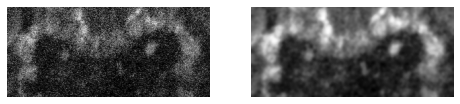

In [119]:
## Motion Correction setup
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
refImg = np.mean(stackMP[0:10,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


In [120]:
def computeMotionShift(stack, refImage, upsampleFactor, sigmaval = 2, doFilter = False, stdFactor = 2, showShiftFig = True):
    from skimage.registration import phase_cross_correlation

    if len(refImage.shape) == 3:
        print('perform motion correction on a volume')
        refImgFilt = refImage.copy()
        for p in range(stack['planes [µm]'].size):
            refImgFilt[p,:,:] = gaussian_filter(refImage[p,:,:], sigma=sigmaval)
        shift = np.zeros((2, stack['planes [µm]'].size,stack['volumes [s]'].size))
        error = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
        diffphase = np.zeros((stack['planes [µm]'].size,stack['volumes [s]'].size))
    else:
        print('perform motion correction on a single plane/max projection')
        refImgFilt = gaussian_filter(refImage, sigma=sigmaval)

        shift = np.zeros((2, stack['volumes [s]'].size))
        error = np.zeros(stack['volumes [s]'].size)
        diffphase = np.zeros(stack['volumes [s]'].size)

    # compute shift
    for i in range(stack['volumes [s]'].size):
        if len(refImage.shape) == 3:
            for p in range(stack['planes [µm]'].size):
                shifImg = stack[i,p,:,:]
                shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

                # compute shift
                shift[:,p,i], error[p,i], diffphase[p,i] = phase_cross_correlation(refImgFilt[p,:,:].data, shifImgFilt,
                                                                             upsample_factor = upsampleFactor)
        else:
            shifImg = stack[i,:,:]
            shifImgFilt = gaussian_filter(shifImg, sigma=sigmaval)

            # compute shift
            shift[:,i], error[i], diffphase[i] = phase_cross_correlation(refImgFilt, shifImgFilt,
                                                                         upsample_factor = upsampleFactor)
    if showShiftFig:
        if len(refImage.shape) == 3:
            fig, axs = plt.subplots(2,1,figsize=(15,6))
            axlab = ['x','y']
            for i, ax in enumerate(axs):
                ax.plot(shift[i,:].T)
                ax.set_xlabel('frames')
                ax.set_ylabel('image shift for {}'.format(axlab[i]))
        else:
            fig, ax = plt.subplots(1,1,figsize=(15,5))
            ax.plot(shift[0,:])
            ax.plot(shift[1,:])
            ax.set_xlabel('frames')
            ax.set_ylabel('image shift/pixel')

    if doFilter:
        shiftFilt_x = shift[0,:].copy()
        shiftFilt_y = shift[1,:].copy()
        shiftFilt_x[abs(shiftFilt_x) > stdFactor*np.std(shiftFilt_x)] = np.nan
        shiftFilt_y[abs(shiftFilt_y) > stdFactor*np.std(shiftFilt_y)] = np.nan

        allT = np.arange(len(shiftFilt_x))
        shiftFilt_x_interp = np.interp(allT, allT[~np.isnan(shiftFilt_x)], shiftFilt_x[~np.isnan(shiftFilt_x)])
        shiftFilt_y_interp = np.interp(allT, allT[~np.isnan(shiftFilt_y)], shiftFilt_y[~np.isnan(shiftFilt_y)])

        if showShiftFig:
            ax.plot(shiftFilt_x_interp,'b')
            ax.plot(shiftFilt_y_interp,'c')

        return np.vstack((shiftFilt_x_interp,shiftFilt_y_interp))
    else:
        return shift



perform motion correction on a single plane/max projection


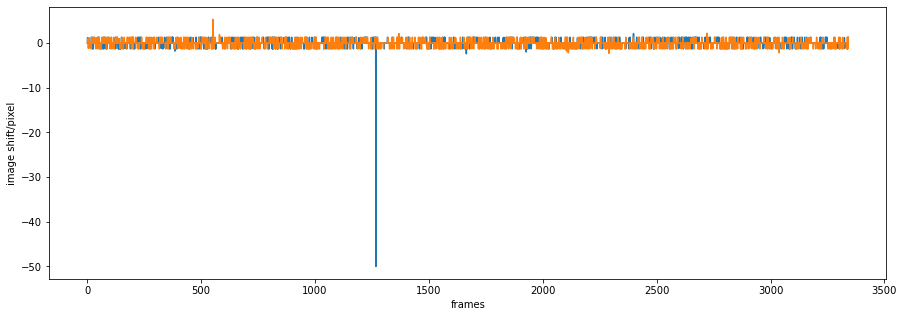

In [121]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [122]:
def motionCorrection(stack, shift):
    from scipy.ndimage import shift as spshift

    #check if shift was calculated for each plane in a volume separately, then check if stack to be aligned is 3d or 4d

    #stack should be an xarray
    stackMC = stack.copy()

    if len(shift.shape) == 3:
        # separate shifts for each plane in a volume
        if len(stack.shape) < 4:
            print("Imaging stack needs to be 4D.")
            return np.nan*stackMC
        for p in range(stack['planes [µm]'].size):
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,p,:,:]
                stackMC[i,p,:,:] = spshift(shifImg, shift[:,p,i], order=1,mode='reflect')

    else:
        #one shift per volume per time point
        if len(stack.shape) < 4:
            # motion correction on single plane or max projection
            for i in range(stack['volumes [s]'].size):
                shifImg = stack[i,:,:]
                stackMC[i,:,:] = spshift(shifImg, shift[:,i], order=1,mode='reflect')
        else:
            #motion correction of 4D stack
            for v in range(stack["volumes [s]"].size):  #move one volume at a time
                tmpVol = stack[{"volumes [s]": v}]
                for p in range(tmpVol["planes [µm]"].size):
                    stackMC[v,p,:,:]  = spshift(tmpVol[p,:,:], shift[:,v], order=1,mode='reflect')

    return stackMC

In [123]:
stack4dMC = motionCorrection(imgStack, shift)

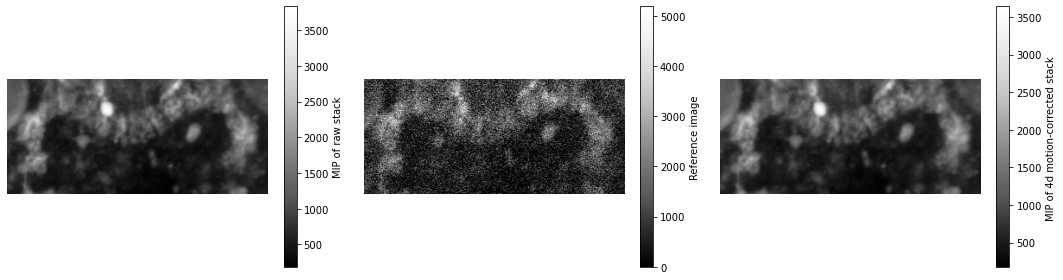

In [124]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [20]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [21]:
#viewer.layers.save('my_file.csv')

In [125]:
stack4dMC.shape

(3342, 9, 134, 302)

In [126]:
label = tifffile.imread("Layer_ROI_1422_009.tif")
#viewer.add_labels(label, name='Labels_16_Roi')

In [127]:
#Load ROI and label from napari
#napari_roi_16 = viewer.layers['Labels_16_Roi'].data
napari_roi_16 = label[0,:,:,:]

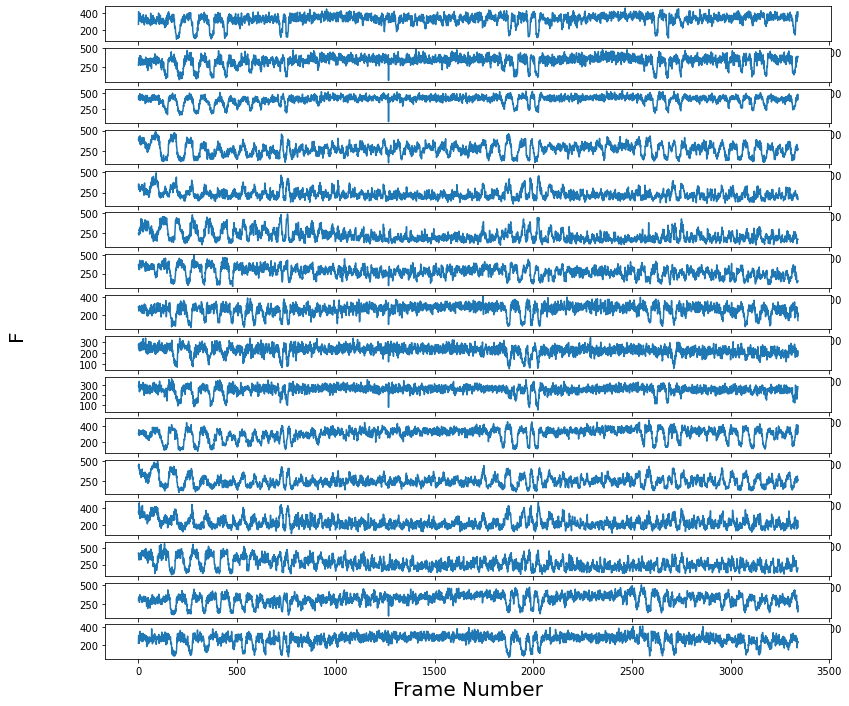

In [128]:
ROI_number = 16
F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
stack4dMC_numpy = stack4dMC.to_numpy()
for time_point in range(stack4dMC['volumes [s]'].size):
        current_volume = stack4dMC_numpy[time_point,:,:,:]
        for ROI_index in range(1, ROI_number + 1):
            mask = napari_roi_16 == ROI_index
            F_array[time_point, ROI_index - 1] =current_volume[mask].mean() 
            
fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(F_array[:,i])
fig.supylabel('F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()
    

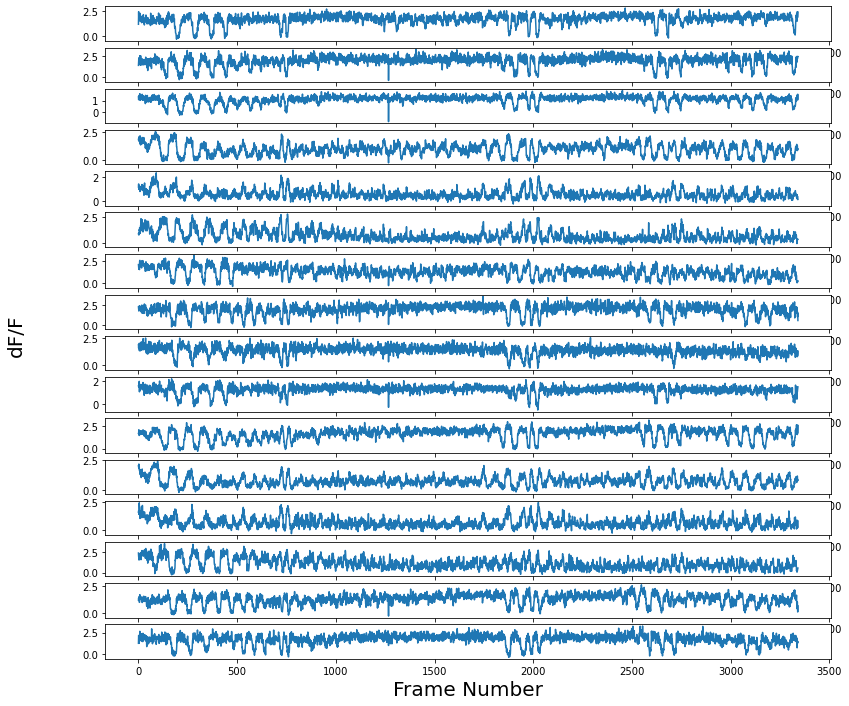

In [129]:
dF_F_array = np.zeros((stack4dMC['volumes [s]'].size, ROI_number))
F_zero = np.quantile(F_array, 0.01, axis = 0)
for F_zero_index in range(ROI_number):
    dF_F_array[:,F_zero_index] = (F_array[:,F_zero_index] - F_zero[F_zero_index])/F_zero[F_zero_index]



fig, axs = plt.subplots(ROI_number, 1, figsize=(13, 12))
for i in range(ROI_number):
    ax = axs[i]
    ax.plot(dF_F_array[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

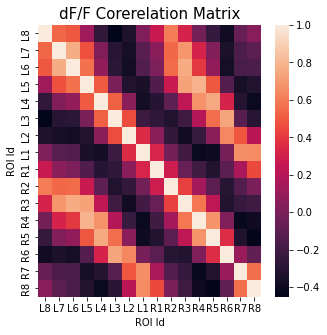

In [130]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe = pd.DataFrame(dF_F_array, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F Corerelation Matrix', fontsize=15)
plt.show()

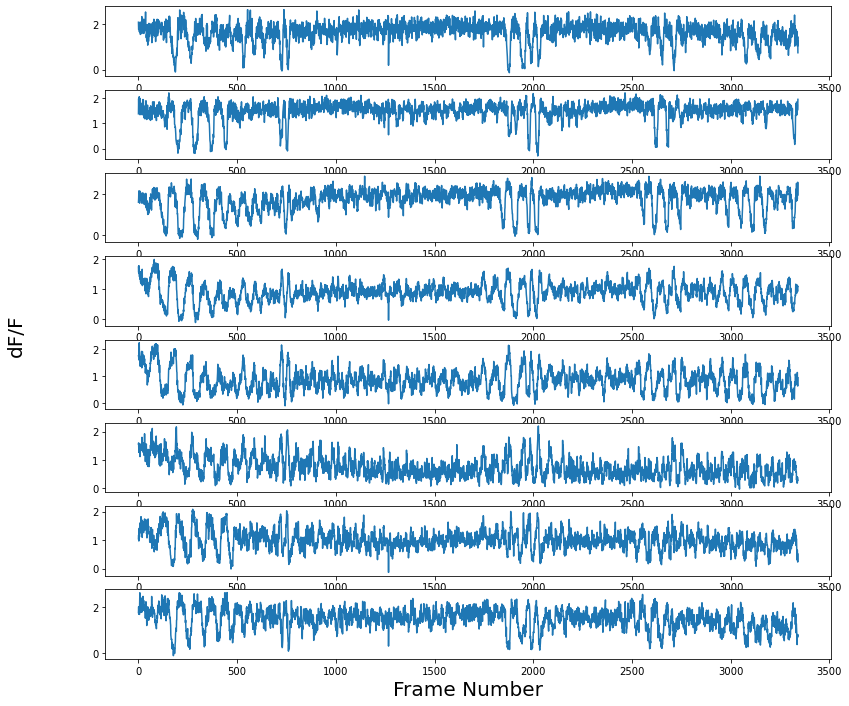

In [131]:
#Combine corresponding glomeruli in left and right PBs, leaving 8 ROIs for calculating PVA
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

ROI_number_combined = 8
dF_F_array_8_roi = np.zeros((stack4dMC['volumes [s]'].size, ROI_number_combined))
for combined_ROI_index in range(ROI_number_combined):
    if combined_ROI_index == ROI_number_combined - 1:
        #Count pixel number to determine the weight of glomeruli L1 & R1 (And put it at first)
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 1)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        #Put it at first
        dF_F_array_8_roi[:,0] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 1] * right_weight
    else:
        #Count pixel number to determine the weight of the rest of each glomeruli 
        pixel_number_left_bridge = np.count_nonzero(napari_roi_16 == combined_ROI_index + 1)
        pixel_number_right_bridge =  np.count_nonzero(napari_roi_16 == combined_ROI_index + 1 + 9)
        left_weight = pixel_number_left_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        right_weight = pixel_number_right_bridge/( pixel_number_left_bridge + pixel_number_right_bridge)
        dF_F_array_8_roi[:,combined_ROI_index + 1] = dF_F_array[:,combined_ROI_index] * left_weight +  dF_F_array[:,combined_ROI_index + 9] * right_weight
        


fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(dF_F_array_8_roi[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Frame Number', fontsize=20)
plt.show()

In [132]:
#Calculate PVA
def PVA_radian_calcul (dff_array, frame_number, ROI_NUM):
    #Assign an angle-array for 8 ROIs ROI1(1R/1L)is0,  ROI2(2R/8L) is 45
    angle_array_roi_8 = [0,np.pi/4,np.pi/2,np.pi*3/4,np.pi,np.pi*5/4,np.pi*3/2,np.pi*7/4]
    #Define a polar 2 cartesian function 
    def pol2cart(rho, phi):
        x = rho * np.cos(phi)
        y = rho * np.sin(phi)
        return x, y
    #Initialize PVA_array 
    PVA_radianArray = np.zeros(frame_number)
    
    for current_PVA_index in range(len(dff_array)):
        temp_x= np.zeros(ROI_NUM)
        temp_y= np.zeros(ROI_NUM)
        for current_ROI_index in range(ROI_NUM):
            temp_x[current_ROI_index], temp_y[current_ROI_index] = pol2cart(dff_array[current_PVA_index,current_ROI_index],angle_array_roi_8[current_ROI_index])
            x_value_PVA = sum(temp_x)
            y_value_PVA = sum(temp_y)
            PVA_radianArray[current_PVA_index] = np.arctan2(y_value_PVA , x_value_PVA )
    
    return PVA_radianArray

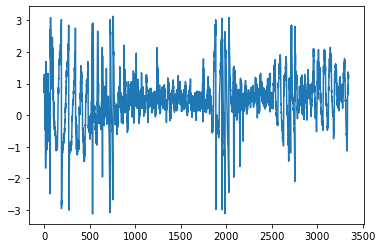

In [133]:
PVA_radian_array = PVA_radian_calcul(dF_F_array_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined)
plt.plot(PVA_radian_array)

In [134]:
import math
def PVA_radian_to_angle(PVA_radian):
    PVA_angle = np.zeros(PVA_radian.size)
    for current_frame in range(len(PVA_radian)):
        if PVA_radian[current_frame] >= 0:
            PVA_angle[current_frame] = math.degrees(PVA_radian[current_frame])
        else:
            PVA_angle[current_frame] = 360 + math.degrees(PVA_radian[current_frame])
    return PVA_angle

In [135]:
PVA_angle_Array = PVA_radian_to_angle(PVA_radian_array)

In [136]:
def PVAangleToRoi (PVA_angle):
    PVA_ROI = np.zeros(PVA_angle.size)
    for current_frame in range(len(PVA_angle)):
        if 0 <= PVA_angle[current_frame] < 45:
            PVA_ROI[current_frame] = 0
        elif 45 <= PVA_angle[current_frame] < 90:
            PVA_ROI[current_frame] = 1
        elif 90 <= PVA_angle[current_frame] < 135:
            PVA_ROI[current_frame] = 2
        elif 135 <= PVA_angle[current_frame] < 180:
            PVA_ROI[current_frame] = 3
        elif 180 <= PVA_angle[current_frame] < 225:
            PVA_ROI[current_frame] = 4
        elif 225 <= PVA_angle[current_frame] < 270:
            PVA_ROI[current_frame] = 5
        elif 270 <= PVA_angle[current_frame] < 315:
            PVA_ROI[current_frame] = 6
        else:
            PVA_ROI[current_frame] = 7
            
    return PVA_ROI

In [137]:
PVA_ROI_assigned = PVAangleToRoi(PVA_angle_Array)

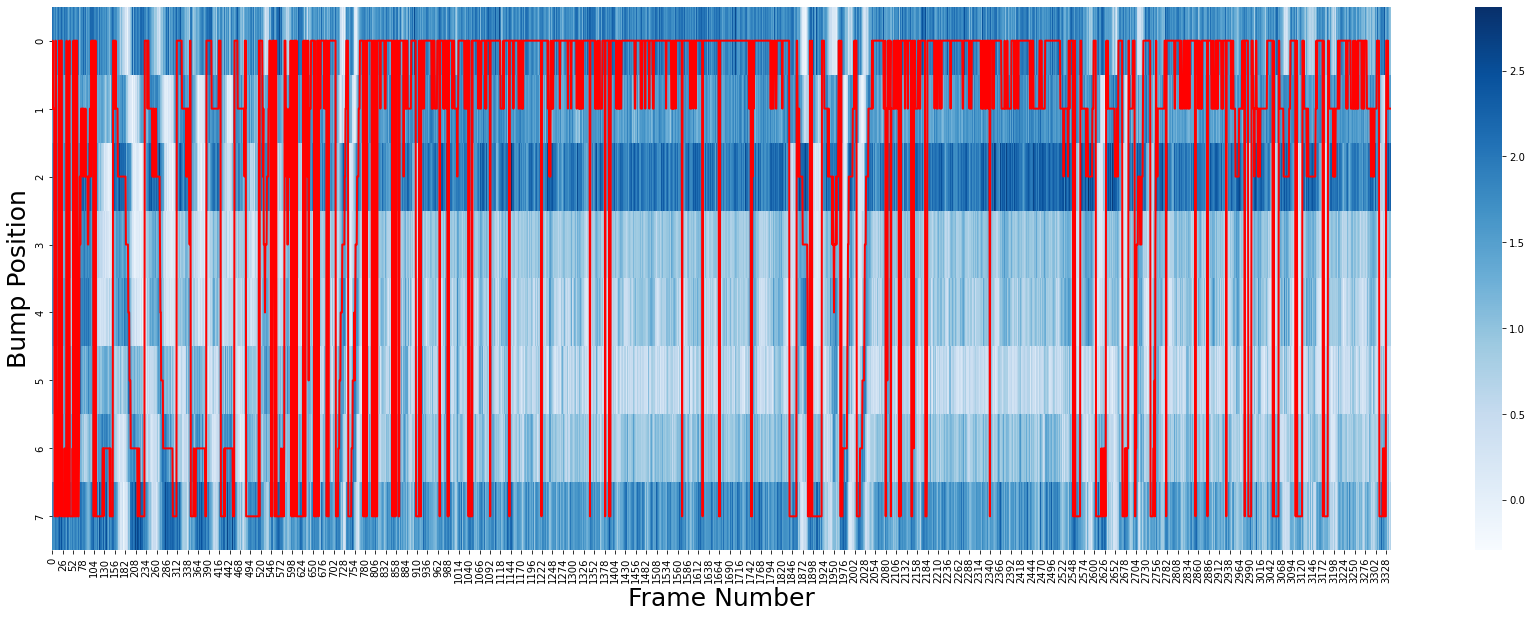

In [138]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
p1 = sns.heatmap(dF_F_array_8_roi.transpose(),cmap='Blues')
sns.color_palette("light:b", as_cmap=True)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
p2 = sns.lineplot(data=PVA_ROI_assigned+0.5,color='red', linewidth =2)
plt.xlabel('Frame Number', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

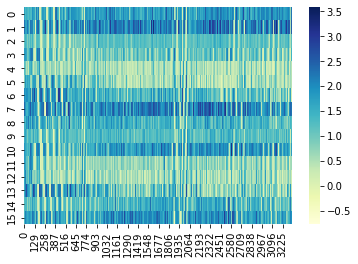

In [139]:
#Plot uncombined 16 ROi all together
p1 = sns.heatmap(dF_F_array.transpose(),cmap='YlGnBu')

In [140]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Desktop/TSeries-08122022-1422-009/TSeries-08122022-1422-009_Cycle00001_VoltageRecording_001.csv')

In [34]:
#Input5 = Heading, Input6 =x , Input7 =y

In [141]:
voltage_recording = voltage_recording.rename(columns={"Time(ms)":"time_ms", " Input 5": "Heading", " Input 6": "x_position", " Input 7": "y_position"})
voltage_recording 

,time_ms,Input 0,Input 1,Input 2,Input 3,Input 4,Heading,x_position,y_position
0,0.000,3.827515,0.037231,0.079956,0.002441,0.003052,1.028748,2.520142,2.496643
1,0.005,4.339600,0.014038,0.073242,3.316040,0.009766,1.028137,2.520752,2.496338
2,0.010,4.633484,0.013733,0.078125,3.315125,0.009460,1.028442,2.520752,2.496643
3,0.015,4.794617,0.014038,0.072327,3.315125,0.009155,1.028137,2.519836,2.496643
4,0.020,4.884033,0.013428,0.078125,3.314514,0.009155,1.027832,2.519531,2.496033
...,...,...,...,...,...,...,...,...,...
60007196,300035.980,0.018311,0.014038,0.071716,0.001221,0.001831,2.987366,1.609497,0.499878
60007197,300035.985,0.018311,0.014038,0.075378,0.001221,0.001526,2.988281,1.609802,0.499573
60007198,300035.990,0.018005,0.013733,0.072021,0.001221,0.001526,2.987366,1.609497,0.499573
60007199,300035.995,0.017700,0.013428,0.075378,0.001526,0.001831,2.987976,1.609802,0.499268


In [142]:
heading_array = voltage_recording ['Heading']

Text(0, 0.5, 'Voltage')

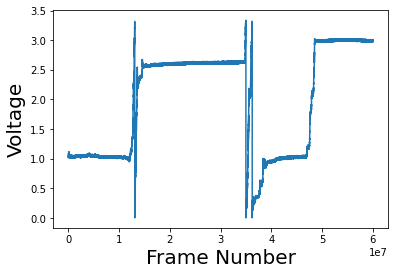

In [143]:
plt.plot(heading_array)
plt.xlabel('Frame Number', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

In [144]:
def fictrack_signal_decoding(unprocessed_heading):
    #Prepocessing the heading array for further analysis
    RadiansArray_heading = unprocessed_heading * np.pi * 2 / np.max(heading_array)
    unwrapped_heading = np.unwrap(RadiansArray_heading)
    
    #Find where is the big jump happening 
    upwrappedIndexes  = np.argwhere(np.absolute(np.diff(RadiansArray_heading)) > np.pi)
    NUM_SAMPLES_FROM_WRAP_TO_REPLACE = 2
    
    for i in range(len(upwrappedIndexes)):
        if upwrappedIndexes[i] < (NUM_SAMPLES_FROM_WRAP_TO_REPLACE -1) and upwrappedIndexes[i] > len(unwrapped_heading) - (NUM_SAMPLES_FROM_WRAP_TO_REPLACE+1):
            upwrappedIndexes.pop(i)
            i = i - 1
    
    #Repplace potentially problematic indexs with NaN\
    cleanedPos = unwrapped_heading
    for j in range(len(upwrappedIndexes)):
        index_start = upwrappedIndexes[j] - NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        index_end = upwrappedIndexes[j] + NUM_SAMPLES_FROM_WRAP_TO_REPLACE 
        cleanedPos[index_start[0]-1:index_end[0]] = np.NaN
        
        #Replace NaN values with the last preceding value that was a real number
        nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    while (len(nanIDX) > 0):
        cleanedPos[nanIDX] = cleanedPos[nanIDX-1]
        nanIDX = np.argwhere(np.isnan(cleanedPos))
    
    cleanedPos = np.absolute(cleanedPos)
    
    plt.plot(cleanedPos)
    plt.xlabel('Frame Number', fontsize=20)
    plt.ylabel('Accumulated rotation (rad)', fontsize=20)
    plt.show()
    
    return cleanedPos

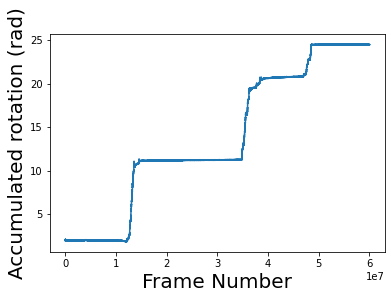

In [145]:
heading_array_processed = fictrack_signal_decoding(heading_array)

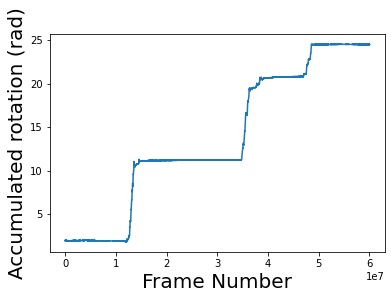

In [146]:
#lowpasfilter heading array
heading_array_processed = low_pass_filter_TQ(heading_array_processed, lowPassCutoff = 90, sampleRate = fictrack_sampling_rate)
plt.plot(heading_array_processed)
plt.xlabel('Frame Number', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.show()

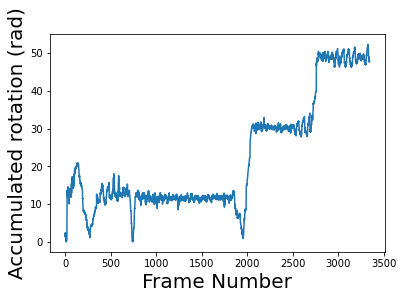

In [147]:
PVA_unwrapped = fictrack_signal_decoding(PVA_radian_array)

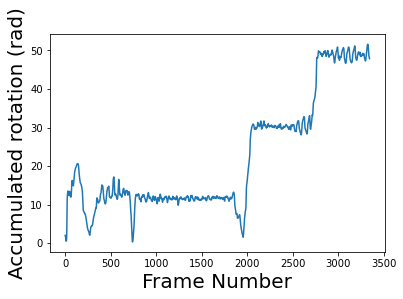

In [148]:
#lowpasfilter PVA array
PVA_unwrapped = low_pass_filter_TQ(PVA_unwrapped, lowPassCutoff = 1, sampleRate = volume_rate)
plt.plot(PVA_unwrapped)
plt.xlabel('Frame Number', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.show()

In [149]:
#Downsampling the heading_array to the 2p volume rate
def downsample_heading_to_total_volume(cycle_number,heading_array_initial):
    from scipy.interpolate import interp1d
    cycle_num = cycle_number
    #Generate  a function based on initial heading arrat to use interpolation to find the value of new points.
    interpolated = interp1d(np.arange(len(heading_array_initial)), heading_array_initial, axis = 0, fill_value = 'extrapolate') 
    downsampled = interpolated(np.linspace(0,len(heading_array_initial), cycle_num))
    
    return downsampled


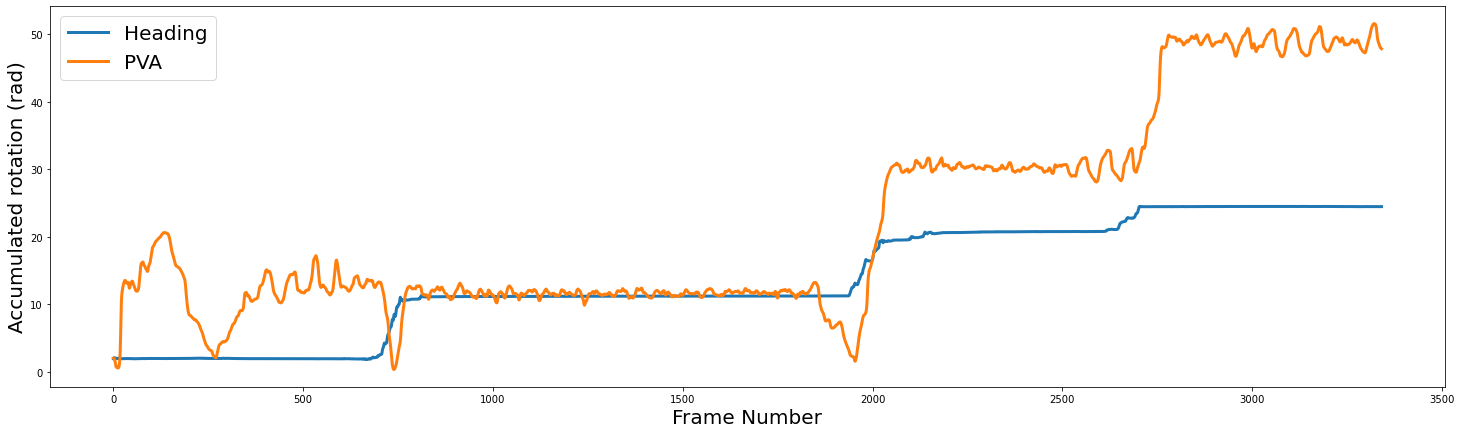

In [150]:
head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(head_array_downsampled,linewidth =3)
plt.plot(PVA_unwrapped,linewidth =3)
plt.xlabel('Frame Number', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)
plt.legend(['Heading','PVA'],fontsize=20)
plt.show()

In [151]:
#Calculate velocity and generate correlation matrix of PVA and Heading
def calculate_PVA_heading_velocity_corr(heading_array, PVA_array, volume_time):
    heading_velocity = np.gradient(heading_array)
    PVA_velocity = np.gradient(PVA_array)
    
    abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > np.pi)
    while (len(abnormal_velocity ) > 0):
        PVA_velocity[abnormal_velocity ] = PVA_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > np.pi)
    
    velocity_corr_array = np.zeros([heading_array.size, 2])
    velocity_corr_array[:,0]=heading_velocity/volume_time
    velocity_corr_array[:,1]=PVA_velocity/volume_time
    
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(velocity_corr_array, columns = ['Turning Velocity', 'PVA Velocity'])
    sns.scatterplot(data = df, x='Turning Velocity', y='PVA Velocity')
    plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
    plt.ylabel('Turning Velocity (Rad/Sec)', fontsize = 10)    
    return PVA_velocity, heading_velocity, df

-0.01932178410825659

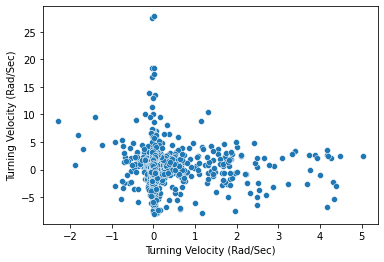

In [152]:
PVA_vel, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(head_array_downsampled, PVA_unwrapped, volume_time=volume_time)
np.corrcoef(PVA_vel,Heading_vel)[0,1]

In [153]:
def shift_for_maximum_correlation(x, y, max_shift_frame):
    
    from scipy.signal import correlate
    from scipy.signal import correlation_lags

    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
                                  
    #find the middle index to consider the frame on both side till max shift frame (1s)
    middle_index = int(len(lags)/2)
    lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    correlation_short = correlation[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    lag = lags_short[np.argmax(np.abs(correlation_short))]
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y, lag

Text(0.5, 1.0, 'Correlation after shifting,lag equals 0.9874700000000001 s, R = 0.13958568656638973')

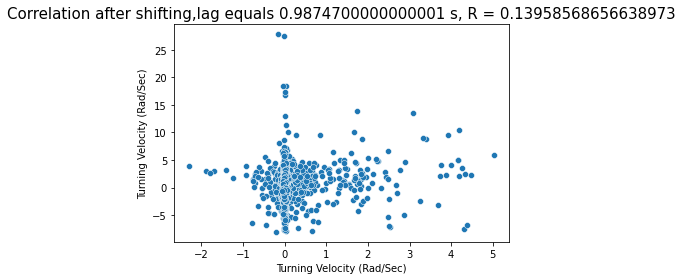

In [155]:
shifted_x, shifted_y, lagframe = shift_for_maximum_correlation(velocity_df['Turning Velocity'], velocity_df['PVA Velocity'], max_shift_frame = round(volume_rate))
shortest = min(shifted_x.shape[0], shifted_y.shape[0])
np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]
velocity_crosscorrelated = pd.concat([shifted_x.iloc[:shortest], shifted_y.iloc[:shortest]], axis=1, join='inner')
import seaborn as sns
sns.scatterplot(data = velocity_crosscorrelated, x='Turning Velocity', y='PVA Velocity')
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
plt.ylabel('Turning Velocity (Rad/Sec)', fontsize = 10)  
plt.title(f"Correlation after shifting,lag equals {np.abs(lagframe) * 0.08977} s, R = {np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]}", fontsize = 15)

In [156]:
# using the downsampled heading array to find the period when fly stop walking 
def find_persistence_period(head_array, degree_of_tolerance, shortest_stopFrame):
    #Convert tolerance to radian since heading array is in radians
    radian_tol = degree_of_tolerance * np.pi/180
    
    persistenceArray = np.zeros(head_array.size)
    for current_frame in range(1,len(head_array)):
        head_current = head_array[current_frame]
        
        previous_bar_positions = head_array[0:current_frame]
        #Absolute value of different from current heading
        absDiffFromCurrent = np.abs(previous_bar_positions - head_current)
        
        aboveThresholdIndex = np.argwhere(absDiffFromCurrent > radian_tol)
        
        if len(aboveThresholdIndex) == 0:
            persistenceArray[current_frame] = current_frame - 1
        else:
            mostRecentAboveThreshold = np.max(aboveThresholdIndex)
            persistenceArray[current_frame] = current_frame - mostRecentAboveThreshold 
       

    return persistenceArray


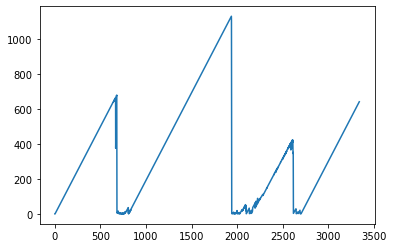

In [157]:
persistence_Array = find_persistence_period(head_array_downsampled,degree_of_tolerance = 10,shortest_stopFrame = 25)
plt.plot(persistence_Array)

In [158]:
def find_stop_period_on_heading(head_velocity_array,degree_of_tolerance,shortest_stopFrame):
    radian_cutoff = degree_of_tolerance * np.pi/180
    stop_index = []
    stop_length = []
    count = 0
    
    for current_volume in range(len(head_velocity_array)):
        #Special case for last index in the array
        if current_volume == len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
                if count >= shortest_stopFrame:
                    stop_index.append(current_volume)
                    stop_length.append(count)
            elif count >= shortest_stopFrame:
                stop_index.append(current_volume-1)
                stop_length.append(count)               
        elif current_volume < len(head_velocity_array) -1:
            if np.abs(head_velocity_array[current_volume]) < radian_cutoff:
                count = count + 1
            elif count < shortest_stopFrame:
                count = 1
            else:
                stop_index.append(current_volume-1)
                stop_length.append(count)
                count = 1
    
    stop_index_length_combined = np.zeros((len(stop_index),2))
    stop_index_length_combined[:,0] = stop_index
    stop_index_length_combined[:,1] = stop_length
    stop_index_length_combined = stop_index_length_combined.astype(int)
    return stop_index_length_combined
        

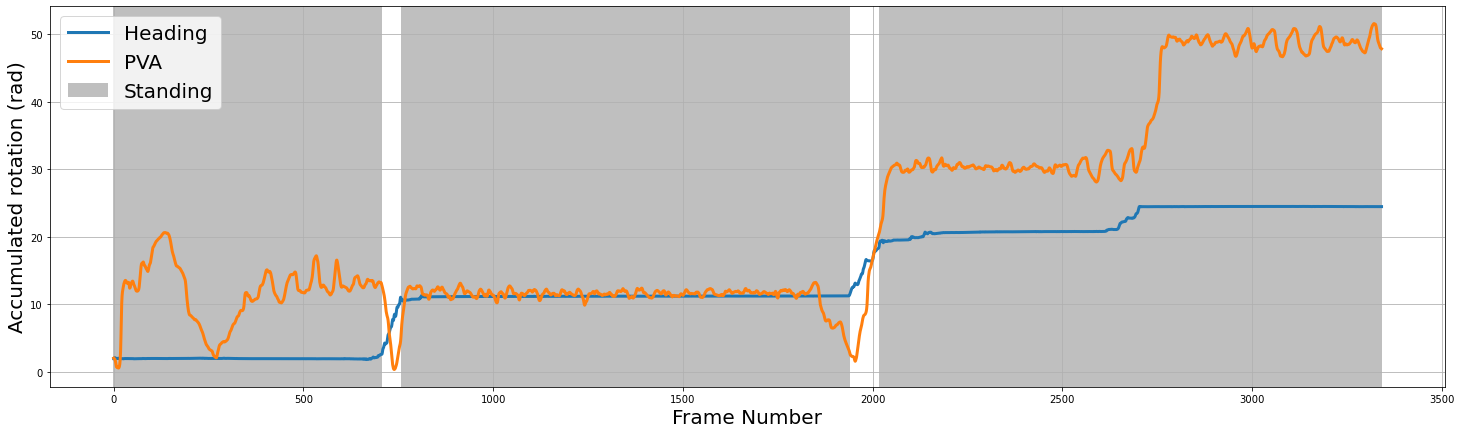

In [159]:
persistence_stop_index_and_length = find_stop_period_on_heading(Heading_vel,degree_of_tolerance =10,shortest_stopFrame=25)
plt.figure(figsize= (25,7))
plt.plot(head_array_downsampled,linewidth =3)
plt.plot(PVA_unwrapped,linewidth =3)
plt.xlabel('Frame Number', fontsize=20)
plt.ylabel('Accumulated rotation (rad)', fontsize=20)

#Plot calculated standing period under shaded area
for i in range(len(persistence_stop_index_and_length)):
    plt.axvspan(persistence_stop_index_and_length[i,0]-persistence_stop_index_and_length[i,1], persistence_stop_index_and_length[i,0], color = 'grey', alpha = 0.5, lw =0,label = 'Standing')
plt.legend(['Heading','PVA','Standing'],fontsize=20)
plt.grid()
plt.show()

In [160]:
def PVA_during_stopPeriod(stop_index_array,PVA_array, volume_time):
    #Initiate output dataframe and 
    df_PVA_stop = pd.DataFrame()
    stop_points = []
    restart_points = []
    restart_points_100ms_before = []
    restart_points_500ms_before = []
    restart_points_2s_before = []
    frame_100ms_before = int(np.ceil(0.1/volume_time))
    frame_500ms_before = int(np.ceil(0.5/volume_time))
    frame_2s_before = int(np.ceil(2/volume_time))
    
    
    for current_index in range(len(stop_index_array)):
        restart_points.append(PVA_array[stop_index_array[current_index,0]])
        stop_points.append(PVA_array[stop_index_array[current_index,0]-stop_index_array[current_index,1]])
        restart_points_100ms_before.append(PVA_array[stop_index_array[current_index,0]-frame_100ms_before])
        restart_points_500ms_before.append(PVA_array[stop_index_array[current_index,0]-frame_500ms_before])
        restart_points_2s_before.append(PVA_array[stop_index_array[current_index,0]-frame_2s_before])
    
    
    df_PVA_stop['PVA_before_stop'] = stop_points
    df_PVA_stop['PVA_at_restart'] = restart_points
    df_PVA_stop['PVA_100ms_before_restart'] = restart_points_100ms_before
    df_PVA_stop['PVA_500ms_before_restart'] = restart_points_500ms_before
    df_PVA_stop['PVA_2s_before_restart'] = restart_points_2s_before
    return df_PVA_stop 

In [161]:
PVA_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_radian_array, volume_time=volume_time)
PVA_at_stop.insert(0,'FlyTrial','TSeries-08122022-1422-009')
PVA_at_stop.insert(1,'Genotype','R60D05>GCaMP8m')

In [162]:
PVA_at_stop

,FlyTrial,Genotype,PVA_before_stop,PVA_at_restart,PVA_100ms_before_restart,PVA_500ms_before_restart,PVA_2s_before_restart
0,TSeries-08122022-1422-009,R60D05>GCaMP8m,1.276232,0.041748,0.566830,0.103555,0.145041
1,TSeries-08122022-1422-009,R60D05>GCaMP8m,-2.671010,2.197156,1.815461,1.440246,-0.522756
2,TSeries-08122022-1422-009,R60D05>GCaMP8m,-0.851377,1.515781,1.332891,1.145703,-0.875035
3,TSeries-08122022-1422-009,R60D05>GCaMP8m,1.539227,0.538544,0.723854,0.913913,-0.560350
4,TSeries-08122022-1422-009,R60D05>GCaMP8m,0.619807,1.276232,1.302728,0.894629,-0.640841


In [163]:
PVA_at_stop.to_csv('PVA_5',encoding = 'utf-8', index=False)

Text(0, 0.5, 'PVA_before_stop (rad)')

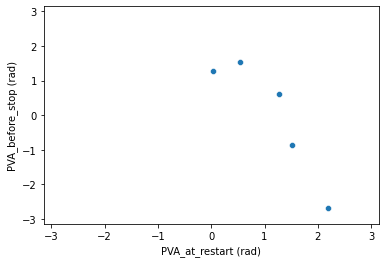

In [164]:
sns.scatterplot(data = PVA_at_stop, x='PVA_at_restart', y='PVA_before_stop')
plt.ylim(-np.pi, np.pi)
plt.xlim(-np.pi, np.pi)
plt.xlabel('PVA_at_restart (rad)')
plt.ylabel('PVA_before_stop (rad)')